In [2]:
# Evaluate the ML model

import tensorflow as tf
from tensorflow import keras
import os
import glob
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
from utils import encoder_files_to_tensors, get_best_model_timestamp
from utils import unnormalize_params
from utils import sample_files
from models import EncoderMulti

# data_dir = './tomo_data/datasets_encoder_TF_16-12-22'
data_dir = './tomo_data/datasets_encoder_TF_03-03-23'

dataset_percent = 0.5
normalization = 'minmax'
img_normalize = 'off'
num_Turns_Case = 1

var_names = ['phEr', 'enEr', 'bl',
             'inten', 'Vrf', 'mu', 'VrfSPS']
# timestamp = get_best_model_timestamp('./trials', model='enc')
# timestamp = '2022_12_18_11-48-57'
# timestamp = '2023_03_03_17-00-48'
timestamp = 'best_encoder_TF'


2023-03-09 15:05:54.774768: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-09 15:05:54.968227: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-03-09 15:05:54.975886: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-03-09 15:05:54

In [3]:
# Initialize parameters
import time

# Initialize train/ test / validation paths
ML_dir = os.path.join(data_dir, 'ML_data')
TESTING_PATH = os.path.join(ML_dir, 'TESTING')
assert os.path.exists(TESTING_PATH)


# First the training data
file_names = sample_files(TESTING_PATH, dataset_percent, keep_every=num_Turns_Case)
print(len(file_names))
start_t = time.time()
# read input, divide in features/ label, create tensors
x_test, y_test = encoder_files_to_tensors(file_names, normalization=normalization,
                                          img_normalize=img_normalize)
total_time = time.time() - start_t
print(f'Elapsed time: {total_time:.3f}, Per file: {total_time/len(file_names):.3f}')


698


2023-03-09 15:05:57.279004: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/kiliakis/install/anaconda3/lib:/home/kiliakis/install/lib
2023-03-09 15:05:57.279020: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-09 15:05:57.279033: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (sy153): /proc/driver/nvidia/version does not exist
2023-03-09 15:05:57.279710: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appr

Elapsed time: 53.710, Per file: 0.077


In [4]:
# Model to load

print(timestamp)

# Initialize directories
trial_dir = os.path.join('./trials/', timestamp)
weights_dir = os.path.join(trial_dir, 'weights')
plots_dir = os.path.join(trial_dir, 'plots')
assert os.path.exists(weights_dir)
os.makedirs(plots_dir, exist_ok=True)

encoder = EncoderMulti(weights_dir)



best_encoder_TF


In [5]:
test_pred = encoder.encode(x_test)
print(test_pred.shape)

(698, 7)


In [6]:
test_losses = {}
for var_name in var_names:
    model = encoder.model[var_names.index(var_name)]
    # if var_name == 'inten':
    #     continue
    idx = var_names.index(var_name)
    print(f'------ Evaluating {var_name} ------')
    test_loss = model.evaluate(x_test, tf.gather(y_test, idx, axis=1))
    # print(test_loss)
    if isinstance(test_loss, float):
        test_losses[var_name] = test_loss
    else:
        test_losses[var_name] = test_loss[0]

for name, mse in test_losses.items():
    print(f'{name}:\t{mse:.3e}')

print(f'\nMean loss: {np.mean([v for v in test_losses.values()]):.3e}')


------ Evaluating phEr ------
22/22 [==============================] - 0s 5ms/step - loss: 2.7721e-06 - mae: 0.0013
------ Evaluating enEr ------
22/22 [==============================] - 0s 3ms/step - loss: 2.0040e-05 - mae: 0.0035
------ Evaluating bl ------
22/22 [==============================] - 0s 4ms/step - loss: 1.8936e-04 - mae: 0.0107
------ Evaluating inten ------
22/22 [==============================] - 0s 5ms/step - loss: 8.9204e-06 - mae: 0.0016
------ Evaluating Vrf ------
22/22 [==============================] - 0s 5ms/step - loss: 2.6599e-05 - mae: 0.0037
------ Evaluating mu ------
22/22 [==============================] - 0s 6ms/step - loss: 6.6311e-04 - mae: 0.0178
------ Evaluating VrfSPS ------
22/22 [==============================] - 0s 5ms/step - loss: 1.2673e-04 - mae: 0.0084
phEr:	2.772e-06
enEr:	2.004e-05
bl:	1.894e-04
inten:	8.920e-06
Vrf:	2.660e-05
mu:	6.631e-04
VrfSPS:	1.267e-04

Mean loss: 1.482e-04


In [7]:

y_test_unnorm = unnormalize_params(
    y_test[:, 0], y_test[:, 1], y_test[:, 2],
    y_test[:, 3], y_test[:, 4], y_test[:, 5],
    y_test[:, 6], normalization=normalization)

y_pred_unnorm = unnormalize_params(
    test_pred[:, 0], test_pred[:, 1], test_pred[:, 2],
    test_pred[:, 3], test_pred[:, 4], test_pred[:, 5],
    test_pred[:, 6], normalization=normalization)

diffs = np.abs(np.array(y_pred_unnorm).T - np.array(y_test_unnorm).T)
print(diffs.shape)



(698, 7)


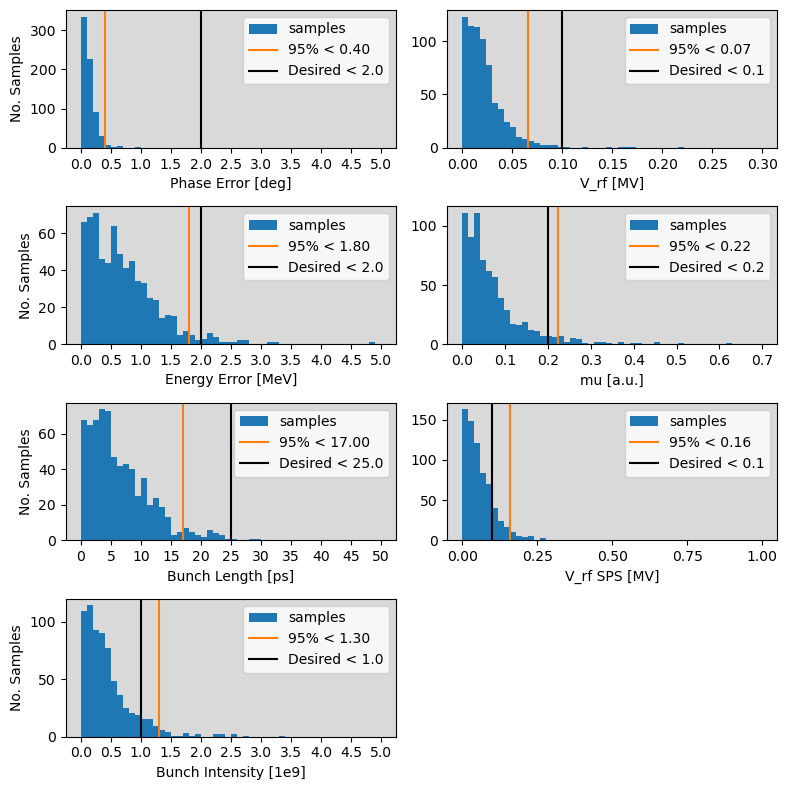

In [8]:
import bisect

# Encoder, graphical evaluation

evaluation_config = {
    0: {'xlabel': 'Phase Error [deg]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    1: {'xlabel': 'Energy Error [MeV]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 2,
        'multiplier': 1},
    2: {'xlabel': 'Bunch Length [ps]',
        'range': (0, 50),
        'xticks': np.arange(0, 50.5, 5),
        'desired': 25,
        'multiplier': 1e12},
    3: {'xlabel': 'Bunch Intensity [1e9]',
        'range': (0, 5),
        'xticks': np.arange(0, 5.1, 0.5),
        'desired': 1,
        'multiplier': 1e-9},
    4: {'xlabel': 'V_rf [MV]',
        'range': (0, 0.3),
        'xticks': np.arange(0, 0.31, 0.05),
        'desired': 0.1,
        'multiplier': 1},
    5: {'xlabel': 'mu [a.u.]',
        'range': (0, 0.7),
        'xticks': np.arange(0, 0.71, 0.1),
        'desired': 0.2,
        'multiplier': 1},
    6: {'xlabel': 'V_rf SPS [MV]',
        'range': (0, 1),
        'xticks': np.arange(0, 1.1, 0.25),
        'desired': 0.1,
        'multiplier': 1},
}

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=False,
                         sharey=False, figsize=(8, 8))
axes = np.ravel(axes, order='F')

for idx, ax in enumerate(axes):
    if idx == 7:
        break
    plt.sca(ax)
    config = evaluation_config[idx]
    hist, bins, _ = plt.hist(
        diffs[:, idx]*config['multiplier'], bins=50, range=config['range'], label='samples')
    cumsum = np.cumsum(hist) / diffs.shape[0]
    b = bisect.bisect(cumsum, 0.95)
    plt.axvline(x=bins[b+1], color='tab:orange',
                label=f'95% < {bins[b+1]:.2f}')
    plt.xticks(config['xticks'])
    plt.xlabel(config['xlabel'])
    if idx < 4:
        plt.ylabel('No. Samples')
    plt.axvline(x=config['desired'], color='black',
                label=f'Desired < {config["desired"]:.1f}')
    plt.legend(loc='upper right')
    plt.gca().set_facecolor('0.85')

# delete last
fig.delaxes(axes[-1])

plt.tight_layout()
plt.savefig(f'plots/enc-abs-error-{timestamp}.jpg',
            dpi=400, bbox_inches='tight')


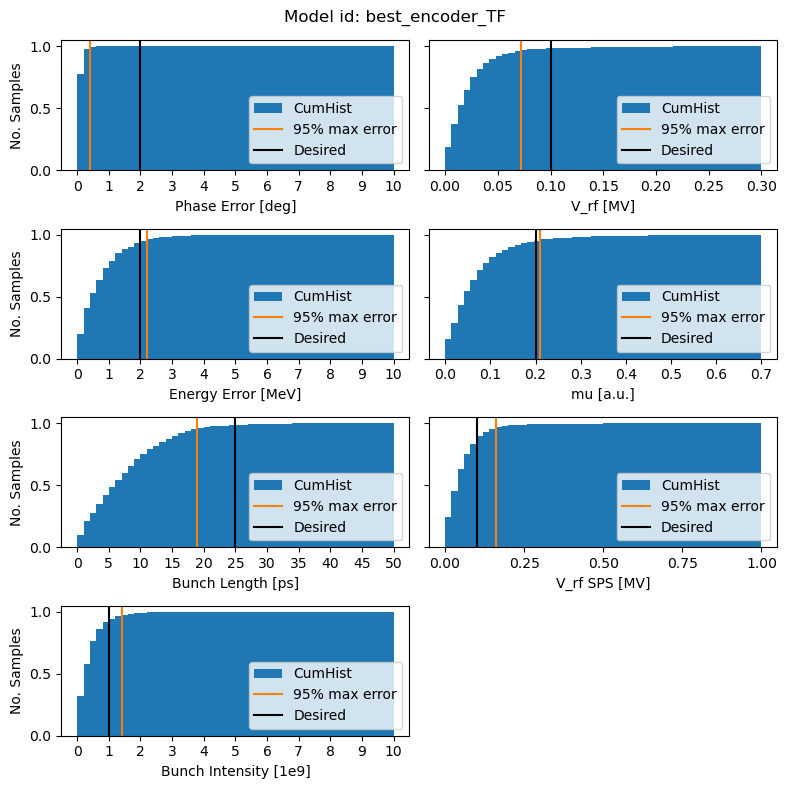

In [49]:
import bisect

fig, axes = plt.subplots(ncols=2, nrows=4, sharex=False,
                         sharey=True, figsize=(8, 8))
fig.suptitle(f'Model id: {timestamp}')

plt.sca(axes[0][0])
n, bins, patches = plt.hist(diffs[:, 0], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Phase Error [deg]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][0])
n, bins, patches = plt.hist(diffs[:, 1], bins=50, range=(0, 10),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5))
plt.xlabel('Energy Error [MeV]')
plt.ylabel('No. Samples')
plt.axvline(x=2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][0])
n, bins, patches = plt.hist(
    diffs[:, 2]*1e12, bins=50, range=(0, 50),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 50.5, 5))
plt.xlabel('Bunch Length [ps]')
plt.ylabel('No. Samples')
plt.axvline(x=25, color='black', label='Desired')
plt.legend(loc='lower right')


plt.sca(axes[3][0])
n, bins, patches = plt.hist(
    diffs[:, 3]*1e-9, bins=50, range=(0, 10),
    cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 10.5, 1))
plt.xlabel('Bunch Intensity [1e9]')
plt.ylabel('No. Samples')
plt.axvline(x=1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[0][1])
n, bins, patches = plt.hist(diffs[:, 4], bins=50, range=(0, 0.3),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xlabel('V_rf [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[1][1])
n, bins, patches = plt.hist(diffs[:, 5], bins=50, range=(0, 0.7),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 0.71, 0.1))
plt.xlabel('mu [a.u.]')
plt.axvline(x=0.2, color='black', label='Desired')
plt.legend(loc='lower right')

plt.sca(axes[2][1])
n, bins, patches = plt.hist(diffs[:, 6], bins=50, range=(0, 1),
                            cumulative=True, density=True, label='CumHist')
b = bisect.bisect(n, 0.95)
plt.axvline(x=bins[b+1], color='tab:orange', label='95% max error')
plt.xticks(np.arange(0, 1.1, 0.25))
plt.xlabel('V_rf SPS [MV]')
plt.axvline(x=0.1, color='black', label='Desired')
plt.legend(loc='lower right')

fig.delaxes(axes[3][1])

plt.tight_layout()
plt.savefig(f'plots/enc-cumulative-hist-{timestamp}.jpg', dpi=400)


In [ ]:
# Also generate MSE histogram
# print(valid_pred.shape)
# square_errors = ((y_test - test_pred) * (y_test - test_pred))

# fig, axes = plt.subplots(ncols=1, nrows=len(var_names), sharex=False,
# sharey=True, figsize=(8, 16))
# for i, name in enumerate(var_names):
#     hist,edges = np.histogram(square_errors[:, i], bins=10, density=False)
#     hist = hist / len(square_errors[:, i])
#     print(name, hist)
#     ax = axes[i]
#     plt.sca(ax)
#     plt.bar(np.arange(len(hist)), hist, width=0.8)
#     plt.title(name)
#     edges = [f'{e:.4f}' for e in edges]
#     plt.xticks(np.arange(len(hist)), edges[1:])
#     plt.xlabel('Error')
#     plt.ylabel('Density')
#     plt.tight_layout()
